<a href="https://colab.research.google.com/github/lauracline/Statistical-Learning-Cookbooks/blob/master/Resampling_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resampling Methods**

## **Cross Validation**

Usually a test set is not avaliable so a simple strategy to create one is to split the avaliable data into training and testing (validation set). For quanitative responses, usually use MSE, for categorical can use error rate, area under the curve, F1 score, weighting of confusion matrix, etc.

## **Leave One Out Cross Validation**

LOOCV has only one observation in the test set and uses all other n-1 observations to build a model. n different models are built leaving out eac observation once and error is averaged over these n trials. LOOCV is better than the simple method above. The model is built on nearly all the data and there is no randomness in the splits since each observation will be left out once. It is computationally expensive especially with large n and a complex model. 

## **K-Fold Cross Validation**

Similiar to LOOCV, but this time you leave some number greater than 1 out. Here, k is the number of partitions of your sample, so if you have 1000 observations and k = 10, then each fold will be 100. These 100 observations would act as your test set. Get an MSE for each fold of these 100 observations and take the average. LOOCV is a special case of k-fold CV whenever k equals the number of observations. 

## **Bias-Variance Tradeoff Between LOOCV and K-Folds**

Since LOOCV trains on nearly all the data, the test error rate will generally be lower than k-fold and therefore less biased. LOOCV will have higher vaariance since all n models will be very highly correlated to one another. Since the models won't differ much, the test error rate (which the CV is measuring) will vary more than k-fold which has fewer models that are less correlated with one another. A value of k between 5 and 10 is a good rule of thumb that balances the trade-off between bias and variance. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Applied Excercises 

1. In chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` dataset. We will now estimate the test error of this logistic regression model using the validation set approach. 

a. Fit a logistic regression model that uses `income` and `balance` to predict `default`. 

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
default = pd.read_csv('https://raw.githubusercontent.com/emredjan/ISL-python/master/datasets/Default.csv')
default['student_yes'] = (default['student'] == 'Yes').astype('int')
default['default_yes'] = (default['default'] == 'Yes').astype('int')

In [4]:
default.head()

,Unnamed: 0,default,student,balance,income,student_yes,default_yes
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,1,0
2,3,No,No,1073.549164,31767.138947,0,0
3,4,No,No,529.250605,35704.493935,0,0
4,5,No,No,785.655883,38463.495879,0,0


In [5]:
X = default[['balance', 'income']]
y = default['default_yes']

No validation set

Using sklearn

In [6]:
# Notice how tol must be changed to less than default value or 
# convergence won't happen
# Use a high value of C to remove regularization 

model = LogisticRegression(C=100000, tol=.0000001)
model.fit(X,y)
model.intercept_, model.coef_

(array([-11.54046839]), array([[5.64710291e-03, 2.08089921e-05]]))

Statsmodels 

Coefficients are similiar

In [7]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
result = smf.logit(formula = 'default_yes ~ balance + income', data=default).fit()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


In [9]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Oct 2021   Pseudo R-squ.:                  0.4594
Time:                        13:05:40   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Error without validation set

This is an in-sample prediction. Training error in both sklearn and statsmodels. Both are equivalent. 

In [10]:
(model.predict(X) == y).mean()

0.9737

In [11]:
((result.predict(X) > .5)*1 == y).mean()

0.9737

b. Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set. 

ii. Fit a multiple logistic regression model using only the training observations. 

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the `default` category if the posterior probability is greater than 0.5. 

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [13]:
model = LogisticRegression(C=100000, tol=0.0000001)
model.fit(X_train, y_train)
model.intercept_, model.coef_

(array([-11.49610613]), array([[5.63979242e-03, 1.90053100e-05]]))

In [14]:
X_train_sm = X_train.join(y_train)

In [15]:
result = smf.logit(formula = 'default_yes ~ balance + income', data=X_train_sm).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.078360
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7497
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Oct 2021   Pseudo R-squ.:                  0.4554
Time:                        13:05:40   Log-Likelihood:                -587.70
converged:                       True   LL-Null:                       -1079.2
Covariance Type:            nonrobust   LLR p-value:                3.501e-214
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.4961      0.501    -22.947      0.000     -12.478     -10.514
balance        0.0056      0.000     21.356      0.000       0.005       0.006
income      1.901e-05    5.8e-06      3.279      0.001    7.65e-06    3.04e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [16]:
# Nearly the same as the training set. So not too much over fitting 
# has happened
(model.predict(X_test) == y_test).mean(), ((result.predict(X_test) > 0.5)*1 == y_test).mean()

(0.974, 0.974)

Validation error is only 0.272. 

c. Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained. 

In [17]:
model = LogisticRegression(C=100000, tol=.0000001)

for i in range(3):
  X_train, X_test, y_train, y_test = train_test_split(X,y)
  model.fit(X_train, y_train)

  X_train_sm = X_train.join(y_train)
  result = smf.logit(formula='default_yes ~ balance + income', data=X_train_sm).fit()
  print((model.predict(X_test) == y_test).mean(), ((result.predict(X_test) > 0.5)*1 == y_test).mean())

Optimization terminated successfully.
         Current function value: 0.080320
         Iterations 10
0.9672 0.9744
Optimization terminated successfully.
         Current function value: 0.079420
         Iterations 10
0.9732 0.9732
Optimization terminated successfully.
         Current function value: 0.080678
         Iterations 10
0.9692 0.9752


d. Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for `student` leads to a reduction in the test error rate. 

In [18]:
X = default[['balance', 'income', 'student_yes']]
y = default['default_yes']

model = LogisticRegression(C=100000, tol=.0000001)

for i in range(3):
  X_train, X_test, y_train, y_test = train_test_split(X,y)
  model.fit(X_train, y_train)

  X_train_sm = X_train.join(y_train)
  result = smf.logit(formula='default_yes ~ balance + income + student_yes', data = X_train_sm).fit()
  print((model.predict(X_test) == y_test).mean(), ((result.predict(X_test) > 0.5)*1 == y_test).mean())

Optimization terminated successfully.
         Current function value: 0.078441
         Iterations 10
0.9732 0.9732
Optimization terminated successfully.
         Current function value: 0.079111
         Iterations 10
0.9676 0.9756
Optimization terminated successfully.
         Current function value: 0.081641
         Iterations 10
0.9668 0.9784


Looks like the error rate is very similiar. 

2. We continue to consider the use of logistic regression model to predict the probability of `default` using `income` and `balance` on the `Default` dataset. In particular, we will now compute estimates for the standard errors of the `income` and `balance` logistic regression coefficients using two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the logistic regression function. 

In [19]:
# Computing standard errors of coefficients of logistic regression 
# using bootstrap

result = smf.logit(formula='default_yes ~ balance + income', data=default).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Oct 2021   Pseudo R-squ.:                  0.4594
Time:                        13:05:41   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [20]:
df_params = pd.DataFrame(columns=['Intercept', 'balance', 'income'])
for i in range(100):
  default_sample = default.sample(len(default), replace=True)
  result_sample = smf.logit(formula = 'default_yes ~ balance + income', data=default_sample).fit(disp=0)
  df_params = df_params.append(result_sample.params, ignore_index=True)

In [21]:
# bootstrap parameters and standard error
df_params.mean(), df_params.std()

(Intercept   -11.564287
 balance       0.005650
 income        0.000021
 dtype: float64, Intercept    0.470132
 balance      0.000263
 income       0.000005
 dtype: float64)

In [22]:
# Model parameters and standard error
result.params, result.bse

(Intercept   -11.540468
 balance       0.005647
 income        0.000021
 dtype: float64, Intercept    0.434772
 balance      0.000227
 income       0.000005
 dtype: float64)

Standard errors are a wee bit lower in bootstrap

3. Compute the LOOCV error for a simple logistic regression model on the `Eekly` dataset. 

A. Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2`. 

In [23]:
weekly = pd.read_csv('https://raw.githubusercontent.com/emredjan/ISL-python/master/datasets/Weekly.csv')

In [24]:
weekly['Direction_Up'] = (weekly['Direction'] == 'Up').astype(int)

In [25]:
weekly.head()

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_Up
0,1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


In [26]:
X = weekly[['Lag1', 'Lag2']]
y = weekly['Direction_Up']

In [27]:
model = LogisticRegression(C=100000, tol=.0000001)
model.fit(X,y)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-07, verbose=0,
                   warm_start=False)

In [28]:
model.intercept_, model.coef_

(array([0.22122405]), array([[-0.03872222,  0.0602483 ]]))

In [29]:
# Accuracy
(model.predict(X) == y).mean()

0.5555555555555556

B. Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2` using all but the first observation. 

In [30]:
# Model is different, but nearly identical
model.fit(X.iloc[1:], y.iloc[1:])
model.intercept_, model.coef_, (model.predict(X) == y).mean()

(array([0.22324305]), array([[-0.03843317,  0.06084763]]), 0.5564738292011019)

C. using the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P(Direction="Up"|Lag1, Lag2) > 0.5. Was this observation correctly classified?

In [31]:
# Wrong prediction 
model.predict([X.iloc[0]]), y[0]

(array([1]), 0)

D. Write a for loop from i = 1 to i = n, where n is the number of observations in the dataset, that performs each of the following steps:

i. Fit a logistic regression model using all but the ith observation to predict `Direction` using `Lag1` and `Lag2`. 

ii. Compute the posterior probability of the market moving up for the ith observation. 

iii. Use the posterior probability for the ith observation in order to predict whether or not the market moves up. 

iv. Determine whether or note an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0. 

In [32]:
np.random.seed(1)
x = np.random.randn(100)
e = np.random.randn(100)
y = x - 1*x**2 + e

In [33]:
y.shape

(100,)

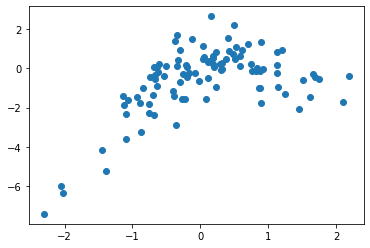

In [34]:
plt.scatter(x,y)

In [35]:
df = pd.DataFrame(np.array([np.ones(len(x)), x, x**2, x**3, x**4, y]).T, columns=['b0', 'x', 'x2', 'x3', 'x4', 'y'])
df.head()

,b0,x,x2,x3,x4,y
0,1.0,1.624345,2.638498,4.285832,6.961671,-1.461281
1,1.0,-0.611756,0.374246,-0.228947,0.140060,0.238505
2,1.0,-0.528172,0.278965,-0.147342,0.077822,-0.403646
3,1.0,-1.072969,1.151262,-1.235268,1.325403,-1.630652
4,1.0,0.865408,0.748930,0.648130,0.560897,-0.978435


In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
X = df.iloc[:, :5]
y = df['y']

model = LinearRegression()
errors = np.zeros((len(X), 4))

for i in range(len(X)):
  leave_out = ~X.index.isin([i])
  for j in range(4):
    model.fit(X.iloc[leave_out, :j+2], y[leave_out])
    errors[i,j] = (model.predict([X.iloc[i, :j+2]]) - y[i])**2

In [38]:
# Each errors here is average error for linear, quadratic, cubic and 
# quartic models
# Looks like it stabilizes at quadratic 
errors.mean(axis=0)

array([2.20767517, 0.91428971, 0.92687688, 0.86691169])

Since the error does not improve after quadratic, it is likely the standard error for x3 and x4 would not be significant. 

4. We will now consider the `Boston` housing dataset, from the `MASS` library. 

In [39]:
boston = pd.read_csv('https://raw.githubusercontent.com/emredjan/ISL-python/master/datasets/Boston.csv')
boston.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


A. Based on this dataset, provide an estimate for the population mean of `medv`. Call this estimate $\hat{\mu}$

In [40]:
boston['medv'].mean()

22.532806324110698

B. Provide an estimate of the standard error $\hat{\mu}$. Interpret this result. 

In [41]:
# Standard deviation of mean 
boston['medv'].std() / np.sqrt(len(boston))

0.4088611474975351

C. Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare with your answer from (B)?

In [42]:
# Boostrap standard deviation of mean 
means = [boston['medv'].sample(n = len(boston), replace=True).mean() for i in range(1000)]
np.std(means)

0.41572510038050287

D. Based on your bootstrap estimate from (C), provide a 95% confidence interval for the mean of `medv`. Compare it to the results obtained using T-Test. 

In [43]:
se = np.std(means)
boston['medv'].mean() - 2 * se, boston['medv'].mean() + 2 * se

(21.701356123349694, 23.364256524871703)

In [44]:
import scipy.stats as st 

In [45]:
st.t.interval(0.95, len(boston['medv'])-1, loc=np.mean(boston['medv']), scale = st.sem(boston['medv']))

(21.729528014578616, 23.33608463364278)

E. Based on this dataset, provide an estimate, $\hat{\mu}_{med}$, for the median value of `medv` in the population. 

In [46]:
boston['medv'].median()

21.2

F. We would now like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using bootstrap. 

In [47]:
medians = [boston['medv'].sample(n=len(boston), replace=True).median() for i in range(1000)]
np.std(medians)

0.38552431829911815

G. Based on this dataset, provide an estimate for the tenth percentile of `medv` in Boston suburbs. Call this quantity $\hat{\mu}_{0.1}$.

In [48]:
boston['medv'].quantile(.1)

12.75

H. Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. 

In [49]:
quantile_10 = [boston['medv'].sample(n = len(boston), replace=True).quantile(.1) for i in range(1000)]
np.std(quantile_10)

0.4945108593347572